# Online learning with TurboGP

This notebook is the follow-up to the previous Simple Regression example notebook. It almost the exact same setup: same problem, same GP individual evolved, same hyperparameters, but one important difference: in this version, SimpleRegresor is evolved via mini-batch training (also known as online learning or incremental learning).

When individuals in GP are evolved through mini-batch evolution, rather than using the entire training dataset in every single evolutionary cycle, only a small subset of the training sample is used instead. A different mini-batch is used each generation. After the population has seen all minibatches, it is said it has elapsed an _epoch_. This terminology is imported from the stochastic gradient descent family of algorithms, from the deep learning framework.

TurboGP was designed with online-learning in mind. It is very easy to implement GP runs that iterate over small subsest of the training sample each cycle. This usually results in large speed gains, reaching same quality solutions in considerable less amount of time; sometimes even better solutions can be achieved with less computational effort, because incremental learning provides a very simple form of _regularization_.

This notebook shows a basic form of online learning with TurboGP. Everything is almost the same except for few more instructions when creating the training dataset, and a two nested `for` loops when performing the evolutionary cycles.

First, let's declare the libraries we will be using:

__(exactly the same as in the previous example)__

In [1]:
%matplotlib notebook

# Required Python libraries
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from networkx.drawing.nx_agraph import graphviz_layout

# TurboGP libraries
from GPIndividuals import *      
from GPOperators import *        
from GPflavors import *          
from LowLevel import *           
from Mezzanine import *          
from HighLevel import *          
from Trimmers import *           
from GPUtils import *            
from Utils import *              

from Regressor import *          # GP individual we will use

# This is useful for when there is overflow, so output cells do not fill with warning messages.
# Disable to debug
import warnings
warnings.simplefilter('ignore')

__Same function to approximate as in the previous example__

<center>$y = sin(x)$</center>


## Sample dataset creation and split-up

Let's create the training dataset, composed of 1000 random samples, in the range of $[-\pi,\pi]$.

__(exactly the same as in the previous example)__

In [2]:
# Training set

# samples
x_training = np.random.rand(1000,1)
x_training = (x_training * 6.28) - 3.14

# labels
y_training = np.sin(x_training).flatten()

Here is where things change a little bit...

We will split our training dataset in 10 minibatches, each composed of 100 training samples. This way, each evolutionary cycle will elapse calculating the error with only 100 samples, rather than 1000.

In [3]:
batchesX = x_training.reshape(10, 100, 1)
batchesY = y_training.reshape(10, 100)

Testing dataset creation remains the same, as there is really no speed-up gain in splitting it up in minibatches too.

In [4]:
# Testing set

# samples
x_testing = np.random.rand(200,1)
x_testing = (x_testing * 6.28) - 3.14

# labels
y_testing = np.sin(x_testing).flatten()

##  TurboGP setup

__GP run hyperparameter remain exactly the same as in the previous example__

In [5]:
# Each of these functions must be properly defined in the corresponding python modules.
lowlevel = ['ADD', 'SUB', 'MUL', 'DIV', 'X2', 'MAX', 'MEAN', 'MIN', 'RELU']
mezzanine = None
highlevel = None


# Now we let the Node objects know the set of input based primitives available at each layer.
Node.f1_set=lowlevel
Node.f2_set=mezzanine
Node.f3_set=highlevel

# This is the range of constants leaf nodes can take a value from (when not taking the form of a input variable)
Node.i2_set=[-1.0,1.0]

In [6]:
pop_size = 1000                                  # Population size

oper = [SimpleRegresor.mutation,                 # Genetic operations to use.
        SimpleRegresor.protected_crossover]      # notice how they are defined by the type of individual we will evolve

oper_prob = [.5, .5]                             # Probabity of each GP operation (in the same order as declared above)
oper_arity = [1, 2]                              # How many parents required by each operation.

l_rate = 1.0                                     # Offspring pool size, defined as the ratio to the population size.

minimization = True                              # if it is a minimization problem or not
sel_mechanism = binary_tournament                # Preferred selection mechanism for parent selection

## Creation of initial population

__Creation of initial population is done in the exact same way as in the previous example, nothing changes__

In [7]:
%%time
Population = []

for _ in range(pop_size):
    Population.append(SimpleRegresor(input_vector_size=1,
                                   complexity = 7))

CPU times: user 956 ms, sys: 52 ms, total: 1.01 s
Wall time: 948 ms


Things change a little bit when evaluating the population for the first time. Since we are using mini-batch training, the most natural thing to do is evaluate the population against one minibatch. In this case we will test them against the last minibatch in our arragement of minibatches.

In [8]:
%%time
#initial evaluation
for individual in Population:
        individual.fitness(batchesX[-1], batchesY[-1])

CPU times: user 880 ms, sys: 0 ns, total: 880 ms
Wall time: 881 ms


As we can see, the evaluation of the entire population of 1000 individuals was ten times faster on one minibatch, compared to when using the entire training set, which makes total sense since each minibatch is a tenth the size of the entire training set.

In each evolutionary cycle, the speed-up will be half of this value, i.e., in this particular example, each evolutionary cycle will elapse five times faster, rather than ten. This is due to the nature of population dynamics under incremental learning, or more specifically, for the case of Steady State (Generational replacement does not suffer this halving in speed up); for a through discussion on this behavior, please refer to: `Rodriguez-Coayahuitl, L., Morales-Reyes, A., & Escalante, H. J. (2019). Evolving autoencoding structures through genetic programming. Genetic Programming and Evolvable Machines, 20(3), 413-440.`

## Evolutionary Cycle

In incremental learning, rather than defining the number of generations, we define the number of _epochs_ we want our algorithm to run for. Then, the actual number of generations is calculated given the number of epochs and the number of minibatches.

In this particular example, notice that, since we have ten minibatches, if we set the GP to run for 5 epochs, 50 generations will elapse, but only in a fifth of the time of the non-incremental version. 

In [9]:
epochs = 5

no_batches = len(batchesX)
Generations = no_batches * epochs

diversity = []
fitness = []
test_fitness = []

Here is where things change somewhat more significantly, because now we need to perform two nested loops: one for the number of epochs, and another inside the first one for the number of mini-batches.

<IPython.core.display.Javascript object>


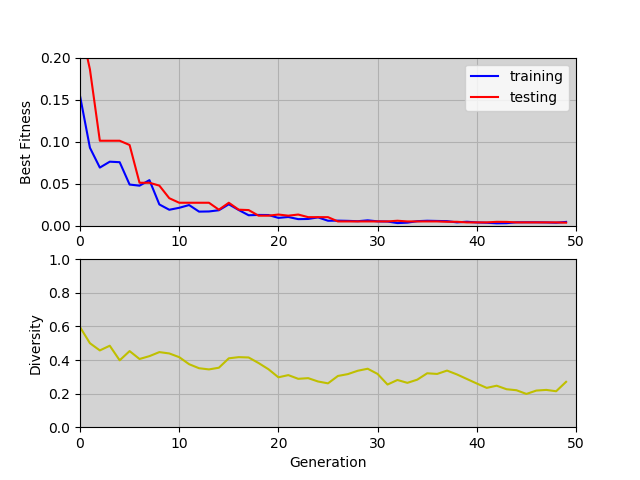

100%|██████████| 50/50 [03:35<00:00,  4.32s/it]


In [10]:
############################################################################################################
# The following piece of code, will allow us to display -in real time- the progress of training fitness,   #
# testing fitness and diversity decay. It is a bit overcomplicated, and it is optional of course, but it   #
# is very useful to understand and visualize if the GP is achieving convergence.                           #

x = list(range(Generations))                                                                               #

y = np.empty(Generations)                                                                                  #
y[:]=np.nan                                                                                                #
y2 = np.empty(Generations)                                                                                 #
y2[:]=np.nan                                                                                               #
d3 = np.empty(Generations)                                                                                 #
d3[:]=np.nan                                                                                               #

plt.ion()                                                                                                  #
fig = plt.figure()                                                                                         #
ax = fig.add_subplot(211)                                                                                  # 
ax.set_ylabel('Best Fitness')                                                                              #
ax.set_ylim(0.0,0.2)                                                                                       #
ax.set_xlim(0,Generations)                                                                                 #
ax.set_facecolor('lightgray')                                                                              #  
ax.grid(True)                                                                                              #
ax2 = fig.add_subplot(212)                                                                                 #
ax2.set_xlabel('Generation')                                                                               #
ax2.set_ylabel('Diversity')                                                                                #
ax2.set_ylim(0.0,1.0)                                                                                      #
ax2.set_xlim(0,Generations)                                                                                #
ax2.set_facecolor('lightgray')                                                                             #
ax2.grid(True)                                                                                             #

line1, = ax.plot(x, y, 'b-', label='training')                                                             #
line2, = ax.plot(x, y2, 'r-', label='testing')                                                             #
line3, = ax2.plot(x, d3, 'y-')                                                                             #
ax.legend()                                                                                                #
############################################################################################################

pbar = tqdm.tqdm(total=Generations)                        

i = 0                          # Notice how now we need to manually count the number of generations elapsed 
for e in range(epochs):
    
    for j in range(no_batches):
        
        Population, d, bf, tf = Steady_State(Population = Population,
                                             batch = batchesX[j],           # different minibatch each cycle
                                             labels = batchesY[j],
                                             test_batch = x_testing,
                                             test_labels = y_testing,
                                             l_rate = l_rate,
                                             oper = oper,
                                             oper_prob = oper_prob,
                                             oper_arity = oper_arity,
                                             minimization = minimization,
                                             sel_mechanism = sel_mechanism,
                                             online = True)  # NOTICE how this parameter is now set to true;
                                             # if online is not set to true, steady state will behave as a 
                                             # pop dynamics called "efficient steady state" that, contrarily 
                                             # to what its name suggests, it is less efficient than regular
                                             # steady state. See paper cited above for more information.
        
        diversity.append(d)
        fitness.append(bf)
        test_fitness.append(tf)

        # For live plotting #################
        y[i]=fitness[i]
        y2[i]=test_fitness[i]
        d3[i]=diversity[i]

        line1.set_ydata(y)
        line2.set_ydata(y2)
        line3.set_ydata(d3)

        fig.canvas.draw()
        #####################################
        
        i += 1
        pbar.update(1)      
    
pbar.close()

We have achieved a better performance than the non online version, in just a fraction of the time. Let's corroborate the results:

In [11]:
print("Training fitness of best individual found: ", fitness[-1])
print("Testing  fitness of best individual found: ", test_fitness[-1])

Training fitness of best individual found:  0.0043754065690908735
Testing  fitness of best individual found:  0.0034893538405757043


The results are expressed in MSE, which is the error measure used by SimpleRegresor class.

Let's extract the best individual from the population in order to display its syntax tree.

In [12]:
solver = elite_selection(population=Population, amount=1, minimization=minimization)[0]

Now, let's plot it and see how it sees...

<IPython.core.display.Javascript object>


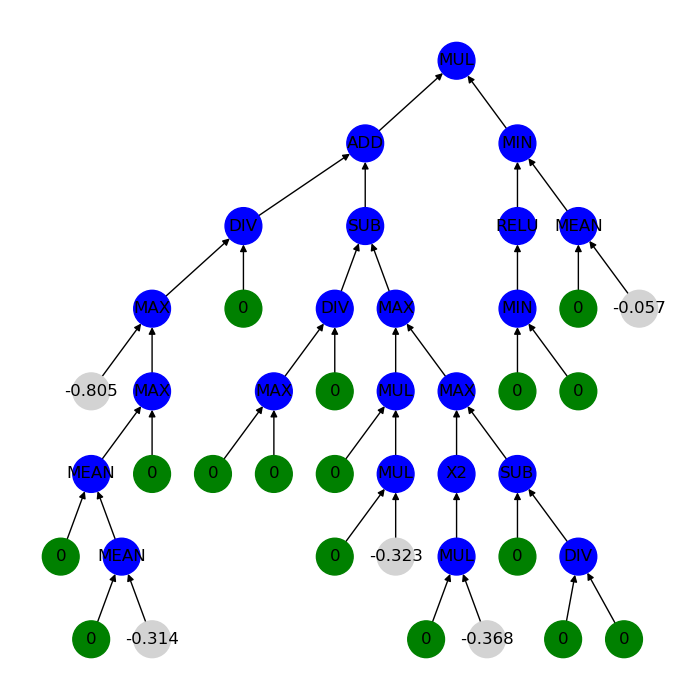

In [13]:
plt.figure(figsize=(7,7))
graph, labels, color_map = get_graph(solver.tree)
nx.draw(graph, pos=nx.nx_agraph.graphviz_layout(graph.reverse(), prog="dot"), with_labels=True, labels=labels, node_size=700, node_color=color_map)

Finally, let's see how does it look the curve that our models approximates, and compare it against the real function...

<IPython.core.display.Javascript object>


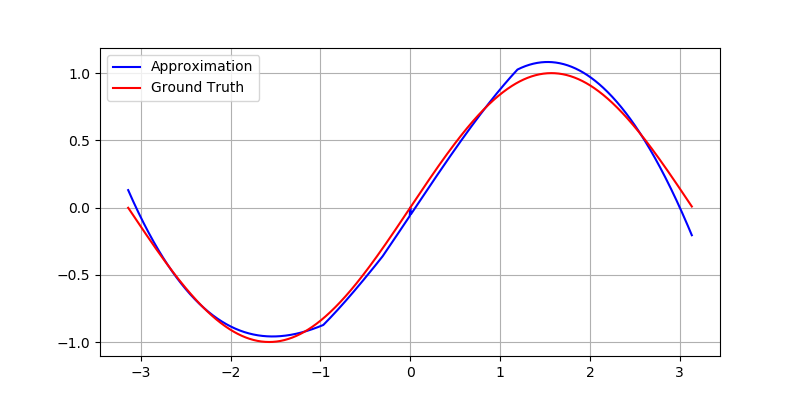

In [14]:
x = np.arange(1000)
x = ((x / 1000) * 6.28) - 3.14
x = x.reshape(1000,1)

y = np.zeros(1000)
y2 = np.zeros(1000)

for i in range(1000):
    y[i] = solver.predict(x[i])
    y2[i] = np.sin(x[i])


fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.grid(True)

line1, = ax.plot(x, y, 'b-', label='Approximation')
line2, = ax.plot(x, y2, 'r-', label='Ground Truth')

ax.legend()
plt.show()

Online learning will -in general- speed up considerably the performance of GP. This is specially true for evolving models with rather big datasets (ten thousand samples and above). 

Another option to increase GP runs' speed, is to use the multiple CPUs/processing threads that are now available in most modern home, scientific and industrial computer systems. Even comercial desktop and laptop (and even SoC's) PCs have now at least 4 CPUs or processing threads. TurboGP supports the use of multiple CPUs. However, it is also important to focus on techniques such as online learning to achieve significant runtime gains.

The combined use of mini-batch learning and multiple CPUs requires to find a fine balance between the number of CPUs used, the size of the minibatches and the size of the population, if parallel algorithmic efficience is to be achieved. Next notebook will discuss in detail the usage of multiple CPUs with TurboGP.